## https://github.com/BCG-Gamma/facet
. sklearndf
# conda install -c bcg_gamma sklearndf 
# conda install sklearndf -c bcg_gamma -c conda-forge
. gamma-facet
## conda install gamma-facet -c bcg_gamma -c conda-forge



In [12]:
# standard imports
import pandas as pd
from sklearn.model_selection import RepeatedKFold

# some helpful imports from sklearndf
from sklearndf.pipeline import RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF

# relevant FACET imports
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid

# # load the diabetes dataset
diabetes_df = pd.read_csv('diabetes_quickstart1.csv')
# from sklearn.datasets import load_diabetes # 匯入Sklearn內建資料集
# diabetes_df = load_diabetes() # 將數據匯入
# print(diabetes_df)

# create FACET sample object
diabetes_sample = Sample(observations=diabetes_df, target_name="Disease_progression")


# Gamma Facet的第一個特徵：找出重要抓手

In [13]:

# create a (trivial) pipeline for a random forest regressor
rnd_forest_reg = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(random_state=42)
)

# define grid of models which are "competing" against each other
rnd_forest_grid = [
    LearnerGrid(
        pipeline=rnd_forest_reg,
        learner_parameters={
            "min_samples_leaf": [8, 11, 15]
        }
    ),
]

# create repeated k-fold CV iterator
rkf_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# rank your candidate models by performance (default is mean CV score - 2*SD)
ranker = LearnerRanker(
    grids=rnd_forest_grid, cv=rkf_cv, n_jobs=-3
).fit(sample=diabetes_sample)

# get summary report
ranker.summary_report()

ranking_score  r2_score                          regressor  \
                        mean       std                     type   
rank                                                              
0         0.316643  0.443901  0.063629  RandomForestRegressorDF   
1         0.315783  0.442023  0.063120  RandomForestRegressorDF   
2         0.314089  0.442691  0.064301  RandomForestRegressorDF   

                       
     min_samples_leaf  
rank                   
0                  11  
1                   8  
2                  15

In [14]:
# fit the model inspector
from facet.inspection import LearnerInspector
inspector = LearnerInspector(n_jobs=-3)
inspector.fit(crossfit=ranker.best_model_crossfit_)

# Synergy

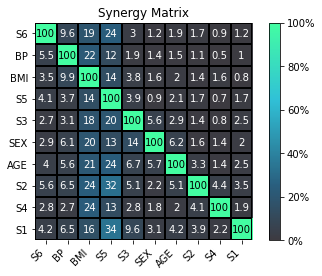

In [15]:
# visualise synergy as a matrix
from pytools.viz.matrix import MatrixDrawer
synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")

# Redundancy

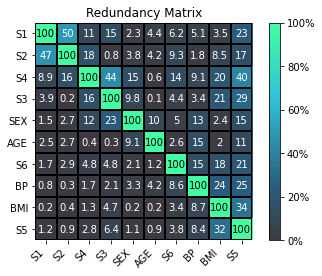

In [16]:
# visualise redundancy as a matrix
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy Matrix")

# Clustering redundancy

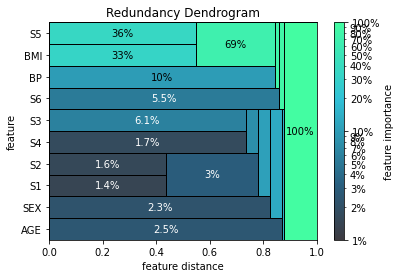

In [17]:
# visualise redundancy using a dendrogram
from pytools.viz.dendrogram import DendrogramDrawer
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(data=redundancy, title="Redundancy Dendrogram")

# Model Simulation

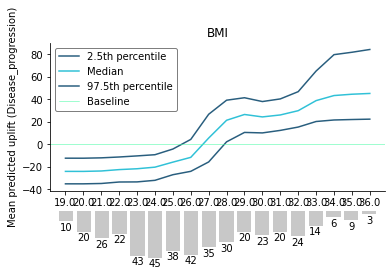

In [18]:
# FACET imports
from facet.validation import BootstrapCV
from facet.crossfit import LearnerCrossfit
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation.viz import SimulationDrawer

# create bootstrap CV iterator
bscv = BootstrapCV(n_splits=1000, random_state=42)

# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=ranker.best_model_,
    cv=bscv,
    n_jobs=-3,
    verbose=False,
).fit(sample=diabetes_sample)

SIM_FEAT = "BMI"
simulator = UnivariateUpliftSimulator(crossfit=boot_crossfit, n_jobs=-3)

# split the simulation range into equal sized partitions
partitioner = ContinuousRangePartitioner()

# run the simulation
simulation = simulator.simulate_feature(feature_name=SIM_FEAT, partitioner=partitioner)

# visualise results
SimulationDrawer().draw(data=simulation, title=SIM_FEAT)